In [1]:
import sys
sys.path.append(
    "/home/katrin/Documents/gammapy"
)
print(sys.path)
import gammapy 
print(f'loaded gammapy version: {gammapy.__version__} ' )
print(f'Supposed to be 1.0 (21-12-2022)' )

['/home/katrin/Documents/nuisance_summary/Eff_area', '/home/katrin/anaconda3/envs/gammapy-dev/lib/python38.zip', '/home/katrin/anaconda3/envs/gammapy-dev/lib/python3.8', '/home/katrin/anaconda3/envs/gammapy-dev/lib/python3.8/lib-dynload', '', '/home/katrin/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages', '/home/katrin/Documents/gammapy']
loaded gammapy version: 0.1.dev19056+g5a5f803 
Supposed to be 1.0 (21-12-2022)


In [2]:
#get_ipython().system('jupyter nbconvert --to script 1-Nui_Par_Fitting.ipynb')
import pyximport

pyximport.install()
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
import gammapy

# from gammapy.datasets import MapDataset
from gammapy.maps import Map
from astropy.coordinates import SkyCoord, Angle
from gammapy.modeling import Fit, Parameter, Parameters, Covariance
from gammapy.datasets import MapDataset #, MapDatasetNuisance
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    create_crab_spectral_model,
    SkyModel,
    PointSpatialModel,
    ShellSpatialModel,
    GeneralizedGaussianSpatialModel,
    TemplateSpatialModel,
    LogParabolaSpectralModel,
    GaussianSpatialModel,
    DiskSpatialModel,
    PowerLawNormSpectralModel,
    Models,
    SpatialModel,
    FoVBackgroundModel,
)
from gammapy.estimators import TSMapEstimator, ExcessMapEstimator

from regions import CircleSkyRegion, RectangleSkyRegion
import yaml
import sys

from Dataset_Creation import sys_dataset

spatial binsize =  [0.08] deg
MapDataset
----------

  Name                            : zQRWEaOr 

  Total counts                    : 388209 
  Total background counts         : 360331.31
  Total excess counts             : 27877.69

  Predicted counts                : 361333.07
  Predicted background counts     : 360331.34
  Predicted excess counts         : 1001.73

  Exposure min                    : 2.07e-01 m2 s
  Exposure max                    : 2.41e+11 m2 s

  Number of total bins            : 540000 
  Number of fit bins              : 180191 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : -924522.99

  Number of models                : 2 
  Number of parameters            : 11
  Number of free parameters       : 7

  Component 0: SkyModel
  
    Name                      : Source
    Datasets names            : None
    Spectral model type       : PowerLawSpectralModel
    Spatial  model type       : GaussianSpatialModel
    Temporal model ty

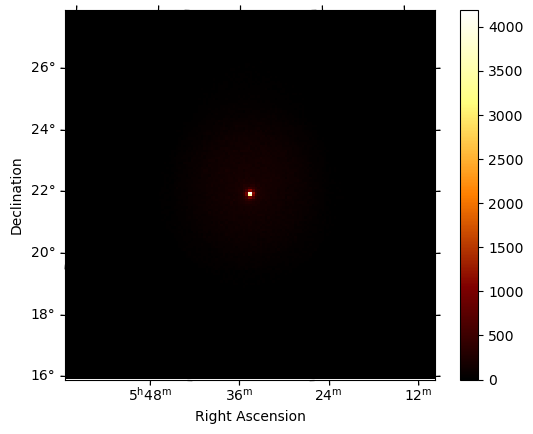

In [3]:
source = 'Crab'
path = '/home/vault/caph/mppi062h/repositories/HESS_3Dbkg_syserror/2-error_in_dataset'
path_crab = '/home/hpc/caph/mppi045h/3D_analysis/N_parameters_in_L/nuisance_summary/Crab'
path_crab = '/home/katrin/Documents/Crab'
path = '/home/katrin/Documents'


dataset_standard = MapDataset.read(f'{path}/{source}/stacked.fits')
dataset_standard = dataset_standard.downsample(4)
models = Models.read(f"{path_crab}/standard_model.yml")
model_spectrum  = PowerLawSpectralModel(
    index=2.3,
    amplitude="1e-12 TeV-1 cm-2 s-1",    )
source_model = SkyModel(spatial_model = models['main source'].spatial_model ,
                       spectral_model = model_spectrum,
                       name = "Source")    
models = Models(source_model)

bkg_model = FoVBackgroundModel(dataset_name=dataset_standard.name)
bkg_model.parameters['tilt'].frozen  = False
models.append(bkg_model)
dataset_standard.models = models

dataset_asimov = dataset_standard.copy()
dataset_asimov.counts = dataset_standard.npred()
models = Models(source_model.copy())
bkg_model = FoVBackgroundModel(dataset_name=dataset_asimov.name)
bkg_model.parameters['tilt'].frozen  = False
models.append(bkg_model)
dataset_asimov.models = models

dataset_asimov= dataset_asimov.slice_by_energy(0.1 *u.TeV, 20 *u.TeV)


dataset_standard.counts.sum_over_axes().plot(add_cbar=1)
binsize = dataset_standard.geoms["geom"].width[1] / dataset_standard.geoms["geom"].data_shape[1]
print(
    "spatial binsize = ",
    binsize
)

print(dataset_standard)

## Varying the Exposure

In [4]:
true_energy = dataset_asimov.counts.geom.axes[0].center.value


shift_neg = -0.1
shift_pos = +0.1
shift_cor = 0.0

tilt_neg = -0.015
tilt_pos = 0.015
tilt_cor = 0



In [5]:
def sum_e(x):
    return x.sum(axis=2).sum(axis=1)

In [6]:
colors  = ['blue', 'green', 'red']

In [7]:
sys_d_cor = sys_dataset(dataset_asimov= dataset_asimov,
                        shift = shift_cor, 
                        tilt = tilt_cor,
                        rnd = False)
dataset_cor = sys_d_cor.create_dataset()

sys_d_neg = sys_dataset(dataset_asimov= dataset_asimov,
                        shift = shift_neg, 
                        tilt = tilt_neg,
                        rnd = False)
dataset_neg = sys_d_neg.create_dataset()

sys_d_pos = sys_dataset(dataset_asimov= dataset_asimov,
                        shift = shift_pos, 
                        tilt = tilt_pos,
                        rnd = False)
dataset_pos = sys_d_pos.create_dataset()



/tmp/ipykernel_18165/690338604.py:34: RuntimeWarning: invalid value encountered in true_divide
  rel_cor = (npred_cor - npred_bkg_cor) / npred_cor
/tmp/ipykernel_18165/690338604.py:35: RuntimeWarning: invalid value encountered in true_divide
  rel_neg = (npred_neg - npred_bkg_neg) / npred_neg
/tmp/ipykernel_18165/690338604.py:36: RuntimeWarning: invalid value encountered in true_divide
  rel_pos = (npred_pos - npred_bkg_pos) / npred_pos


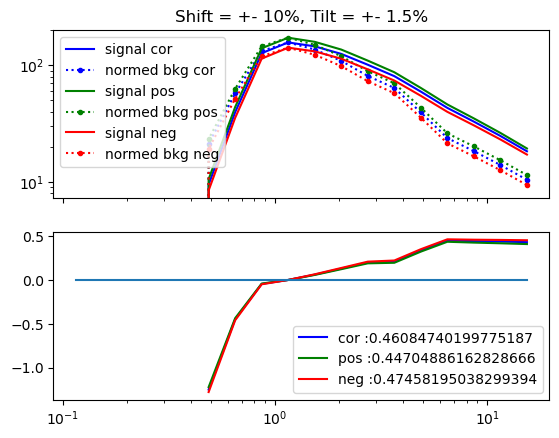

In [8]:
fig,axs = plt.subplots(2,1, sharex = True)
ax =axs[0]

npred_pos =     dataset_pos.npred_signal().data.sum(axis = 2).sum(axis= 1)
npred_bkg_pos = dataset_pos.npred_background().data.sum(axis = 2).sum(axis= 1)
npred_bkg_pos /= max(npred_bkg_pos)
npred_bkg_pos *= max(npred_pos)
npred_neg =     dataset_neg.npred_signal().data.sum(axis = 2).sum(axis= 1)
npred_bkg_neg =     dataset_cor.npred_background().data.sum(axis = 2).sum(axis= 1)
npred_bkg_neg /= max(npred_bkg_neg)
npred_bkg_neg *= max(npred_neg)
npred_cor =     dataset_cor.npred_signal().data.sum(axis = 2).sum(axis= 1)
npred_bkg_cor =     dataset_cor.npred_background().data.sum(axis = 2).sum(axis= 1)
npred_bkg_cor /= max(npred_bkg_cor)
npred_bkg_cor *= max(npred_cor)


ax.plot(true_energy, npred_cor, label = 'signal cor', color = colors[0])
ax.plot(true_energy, npred_bkg_cor, ':.', label = 'normed bkg cor', color = colors[0])

ax.plot(true_energy, npred_pos, label = 'signal pos', color = colors[1])
ax.plot(true_energy, npred_bkg_pos, ':.', label = 'normed bkg pos', color = colors[1])

ax.plot(true_energy, npred_neg, label = 'signal neg', color = colors[2])
ax.plot(true_energy, npred_bkg_neg, ':.', label = 'normed bkg neg', color = colors[2])

ax.legend()
ax.set_xscale('log')
ax.set_yscale("log")

ax.set_title("Shift = +- 10%, Tilt = +- 1.5%")

ax2 = axs[1]
rel_cor = (npred_cor - npred_bkg_cor) / npred_cor
rel_neg = (npred_neg - npred_bkg_neg) / npred_neg
rel_pos = (npred_pos - npred_bkg_pos) / npred_pos


ax2.plot(true_energy, rel_cor, label = "cor :"+str(np.sqrt(np.nanmean(rel_cor**2))), color = colors[0])
ax2.plot(true_energy, rel_pos, label = "pos :"+str(np.sqrt(np.nanmean(rel_pos**2))), color = colors[1])
ax2.plot(true_energy, rel_neg, label = "neg :"+str(np.sqrt(np.nanmean(rel_neg**2))), color = colors[2])
ax2.legend()
ax2.plot(true_energy, [0] * len(true_energy))

/tmp/ipykernel_18165/2411568850.py:61: RuntimeWarning: invalid value encountered in true_divide
  rel_cor = (npred_cor - npred_bkg_cor) / npred_cor
/tmp/ipykernel_18165/2411568850.py:62: RuntimeWarning: invalid value encountered in true_divide
  rel_neg = (npred_neg - npred_bkg_neg) / npred_neg
/tmp/ipykernel_18165/2411568850.py:63: RuntimeWarning: invalid value encountered in true_divide
  rel_pos = (npred_pos - npred_bkg_pos) / npred_pos


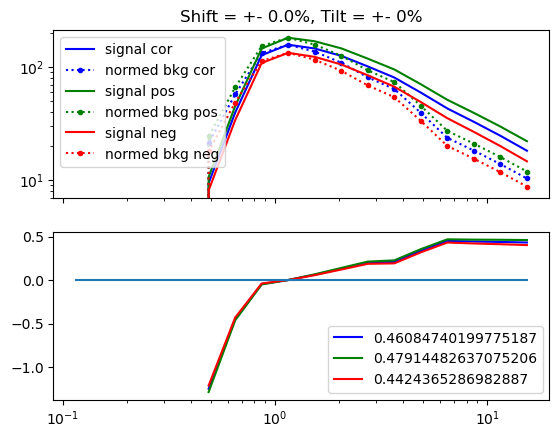

In [9]:


shift_neg = -0.15
shift_pos = +0.15
shift_cor = 0.0

tilt_neg = +0.02
tilt_pos = -0.02
tilt_cor = 0

sys_d_cor = sys_dataset(dataset_asimov= dataset_asimov,
                        shift = shift_cor, 
                        tilt = tilt_cor,
                        rnd = False)
dataset_cor = sys_d_cor.create_dataset()

sys_d_neg = sys_dataset(dataset_asimov= dataset_asimov,
                        shift = shift_neg, 
                        tilt = tilt_neg,
                        rnd = False)
dataset_neg = sys_d_neg.create_dataset()

sys_d_pos = sys_dataset(dataset_asimov= dataset_asimov,
                        shift = shift_pos, 
                        tilt = tilt_pos,
                        rnd = False)
dataset_pos = sys_d_pos.create_dataset()



fig,axs = plt.subplots(2,1, sharex = True)
ax =axs[0]

npred_pos =     dataset_pos.npred_signal().data.sum(axis = 2).sum(axis= 1)
npred_bkg_pos = dataset_pos.npred_background().data.sum(axis = 2).sum(axis= 1)
npred_bkg_pos /= max(npred_bkg_pos)
npred_bkg_pos *= max(npred_pos)
npred_neg =     dataset_neg.npred_signal().data.sum(axis = 2).sum(axis= 1)
npred_bkg_neg =     dataset_cor.npred_background().data.sum(axis = 2).sum(axis= 1)
npred_bkg_neg /= max(npred_bkg_neg)
npred_bkg_neg *= max(npred_neg)
npred_cor =     dataset_cor.npred_signal().data.sum(axis = 2).sum(axis= 1)
npred_bkg_cor =     dataset_cor.npred_background().data.sum(axis = 2).sum(axis= 1)
npred_bkg_cor /= max(npred_bkg_cor)
npred_bkg_cor *= max(npred_cor)


ax.plot(true_energy, npred_cor, label = 'signal cor', color = colors[0])
ax.plot(true_energy, npred_bkg_cor, ':.', label = 'normed bkg cor', color = colors[0])

ax.plot(true_energy, npred_pos, label = 'signal pos', color = colors[1])
ax.plot(true_energy, npred_bkg_pos, ':.', label = 'normed bkg pos', color = colors[1])

ax.plot(true_energy, npred_neg, label = 'signal neg', color = colors[2])
ax.plot(true_energy, npred_bkg_neg, ':.', label = 'normed bkg neg', color = colors[2])

ax.legend()
ax.set_xscale('log')
ax.set_yscale("log")
ax.set_title(f"Shift = +- {shift_cor*100}%, Tilt = +- {tilt_cor*100}%")

ax2 = axs[1]
rel_cor = (npred_cor - npred_bkg_cor) / npred_cor
rel_neg = (npred_neg - npred_bkg_neg) / npred_neg
rel_pos = (npred_pos - npred_bkg_pos) / npred_pos


def factor(rel):
    return  np.sqrt(np.nanmean(rel**2))

factor_cor = factor(rel_cor)
factor_pos = factor(rel_pos)
factor_neg = factor(rel_neg)

ax2.plot(true_energy, rel_cor, label = factor_cor, color = colors[0])
ax2.plot(true_energy, rel_pos, label = factor_pos, color = colors[1])
ax2.plot(true_energy, rel_neg, label = factor_neg, color = colors[2])
ax2.legend()
ax2.plot(true_energy, [0] * len(true_energy))

In [10]:
def compute_sim_factor(shift, tilt):
    sys_d_cor = sys_dataset(dataset_asimov= dataset_asimov,
                        shift = shift, 
                        tilt = tilt,
                        rnd = False)
    dataset_cor = sys_d_cor.create_dataset()
    npred_cor =     dataset_cor.npred_signal().data.sum(axis = 2).sum(axis= 1)
    npred_bkg_cor =     dataset_cor.npred_background().data.sum(axis = 2).sum(axis= 1)
    npred_bkg_cor /= max(npred_bkg_cor)
    npred_bkg_cor *= max(npred_cor)
    rel_cor = (npred_cor - npred_bkg_cor) / npred_cor
    factor = np.sqrt(np.nanmean(rel_cor**2))
    return factor, dataset_cor

In [11]:
N_shifts = 5
shifts = np.linspace(-0.1, 0.1, N_shifts)
N_tilts = 5
tilts = np.linspace(-0.015, 0.015, N_tilts)


In [12]:
%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt




# interpretation:
question was, if the bkg distribution looks more similar to certain shift and tilt pairs than for others. This would lead to a larger error on the bkg norm. A small value means more similarity. The problematic region at shift = -0.1 and tilt of 0.0 does not stand out.

In [13]:
def sim_factor(dataset):
    npred_cor =     dataset.npred_signal().data.sum(axis = 2).sum(axis= 1)
    npred_bkg_cor =     dataset.npred_background().data.sum(axis = 2).sum(axis= 1)
    npred_bkg_cor /= max(npred_bkg_cor)
    npred_bkg_cor *= max(npred_cor)
    rel_cor = (npred_cor - npred_bkg_cor) / npred_cor
    factor = np.sqrt(np.nanmean(rel_cor**2))
    return factor

def compute_sim_factor_after_fit(shift, tilt, careful = False):
    sys_d_cor = sys_dataset(dataset_asimov= dataset_asimov,
                        shift = shift, 
                        tilt = tilt,
                        rnd = False)
    dataset_cor = sys_d_cor.create_dataset()
    fit = Fit()
    if careful:
        minuit_opts = {"tol": 0.001, "strategy": 2}
        fit.backend = "minuit"
        fit.optimize_opts = minuit_opts
    result = fit.run([dataset_cor])
    factor = sim_factor(dataset_cor)
    return factor, dataset_cor, fit

## Default Fitting

In [14]:
%%time

fitting = True
factors_after = []
factors = []
fits = []
datasets_after = []
for s in shifts:
    print(s)
    factors_s = []
    fits_s = []
    factors_s_after = []
    datasets_s = []
    for t in tilts:
        if fitting:
            f, dataset_cor, fit = compute_sim_factor_after_fit(s,t, careful = False)
            factors_s.append(f)
            fits_s.append(fit)
            datasets_s.append(dataset_cor)
            dataset_cor.models.write(f'data/test_datasets_models/1a_dataset_{s}_{t}.yml',overwrite= True)
            f = sim_factor(dataset_cor)
            factors_s_after.append(f)
                      
            
        else:
            f, dataset_cor = compute_sim_factor(s,t)
            factors_s.append(f)
            model = Models.read(f'data/test_datasets_models/1a_dataset_{s}_{t}.yml')
            model[1].datasets_names =dataset_cor.name
            dataset_cor.models = model
            f = sim_factor(dataset_cor)
            factors_s_after.append(f)
            datasets_s.append(dataset_cor)
            fits_s.append(None)
    factors_after.append(factors_s_after)
    factors.append(factors_s)
    datasets_after.append(datasets_s)
    fits.append(fits_s)
    

-0.1


/tmp/ipykernel_18165/3637155613.py:6: RuntimeWarning: invalid value encountered in true_divide
  rel_cor = (npred_cor - npred_bkg_cor) / npred_cor
/tmp/ipykernel_18165/3637155613.py:6: RuntimeWarning: invalid value encountered in true_divide
  rel_cor = (npred_cor - npred_bkg_cor) / npred_cor
/tmp/ipykernel_18165/3637155613.py:6: RuntimeWarning: invalid value encountered in true_divide
  rel_cor = (npred_cor - npred_bkg_cor) / npred_cor
/tmp/ipykernel_18165/3637155613.py:6: RuntimeWarning: invalid value encountered in true_divide
  rel_cor = (npred_cor - npred_bkg_cor) / npred_cor
/tmp/ipykernel_18165/3637155613.py:6: RuntimeWarning: invalid value encountered in true_divide
  rel_cor = (npred_cor - npred_bkg_cor) / npred_cor
/tmp/ipykernel_18165/3637155613.py:6: RuntimeWarning: invalid value encountered in true_divide
  rel_cor = (npred_cor - npred_bkg_cor) / npred_cor
/tmp/ipykernel_18165/3637155613.py:6: RuntimeWarning: invalid value encountered in true_divide
  rel_cor = (npred_cor 

-0.05


/tmp/ipykernel_18165/3637155613.py:6: RuntimeWarning: invalid value encountered in true_divide
  rel_cor = (npred_cor - npred_bkg_cor) / npred_cor
/tmp/ipykernel_18165/3637155613.py:6: RuntimeWarning: invalid value encountered in true_divide
  rel_cor = (npred_cor - npred_bkg_cor) / npred_cor
/tmp/ipykernel_18165/3637155613.py:6: RuntimeWarning: invalid value encountered in true_divide
  rel_cor = (npred_cor - npred_bkg_cor) / npred_cor
/tmp/ipykernel_18165/3637155613.py:6: RuntimeWarning: invalid value encountered in true_divide
  rel_cor = (npred_cor - npred_bkg_cor) / npred_cor
/tmp/ipykernel_18165/3637155613.py:6: RuntimeWarning: invalid value encountered in true_divide
  rel_cor = (npred_cor - npred_bkg_cor) / npred_cor
/tmp/ipykernel_18165/3637155613.py:6: RuntimeWarning: invalid value encountered in true_divide
  rel_cor = (npred_cor - npred_bkg_cor) / npred_cor
/tmp/ipykernel_18165/3637155613.py:6: RuntimeWarning: invalid value encountered in true_divide
  rel_cor = (npred_cor 

0.0


/tmp/ipykernel_18165/3637155613.py:6: RuntimeWarning: invalid value encountered in true_divide
  rel_cor = (npred_cor - npred_bkg_cor) / npred_cor
/tmp/ipykernel_18165/3637155613.py:6: RuntimeWarning: invalid value encountered in true_divide
  rel_cor = (npred_cor - npred_bkg_cor) / npred_cor
/tmp/ipykernel_18165/3637155613.py:6: RuntimeWarning: invalid value encountered in true_divide
  rel_cor = (npred_cor - npred_bkg_cor) / npred_cor
/tmp/ipykernel_18165/3637155613.py:6: RuntimeWarning: invalid value encountered in true_divide
  rel_cor = (npred_cor - npred_bkg_cor) / npred_cor
/tmp/ipykernel_18165/3637155613.py:6: RuntimeWarning: invalid value encountered in true_divide
  rel_cor = (npred_cor - npred_bkg_cor) / npred_cor
/tmp/ipykernel_18165/3637155613.py:6: RuntimeWarning: invalid value encountered in true_divide
  rel_cor = (npred_cor - npred_bkg_cor) / npred_cor
/tmp/ipykernel_18165/3637155613.py:6: RuntimeWarning: invalid value encountered in true_divide
  rel_cor = (npred_cor 

0.05000000000000002


/tmp/ipykernel_18165/3637155613.py:6: RuntimeWarning: invalid value encountered in true_divide
  rel_cor = (npred_cor - npred_bkg_cor) / npred_cor
/tmp/ipykernel_18165/3637155613.py:6: RuntimeWarning: invalid value encountered in true_divide
  rel_cor = (npred_cor - npred_bkg_cor) / npred_cor
/tmp/ipykernel_18165/3637155613.py:6: RuntimeWarning: invalid value encountered in true_divide
  rel_cor = (npred_cor - npred_bkg_cor) / npred_cor
/tmp/ipykernel_18165/3637155613.py:6: RuntimeWarning: invalid value encountered in true_divide
  rel_cor = (npred_cor - npred_bkg_cor) / npred_cor
/tmp/ipykernel_18165/3637155613.py:6: RuntimeWarning: invalid value encountered in true_divide
  rel_cor = (npred_cor - npred_bkg_cor) / npred_cor
/tmp/ipykernel_18165/3637155613.py:6: RuntimeWarning: invalid value encountered in true_divide
  rel_cor = (npred_cor - npred_bkg_cor) / npred_cor
/tmp/ipykernel_18165/3637155613.py:6: RuntimeWarning: invalid value encountered in true_divide
  rel_cor = (npred_cor 

0.1


/tmp/ipykernel_18165/3637155613.py:6: RuntimeWarning: invalid value encountered in true_divide
  rel_cor = (npred_cor - npred_bkg_cor) / npred_cor
/tmp/ipykernel_18165/3637155613.py:6: RuntimeWarning: invalid value encountered in true_divide
  rel_cor = (npred_cor - npred_bkg_cor) / npred_cor
/tmp/ipykernel_18165/3637155613.py:6: RuntimeWarning: invalid value encountered in true_divide
  rel_cor = (npred_cor - npred_bkg_cor) / npred_cor
/tmp/ipykernel_18165/3637155613.py:6: RuntimeWarning: invalid value encountered in true_divide
  rel_cor = (npred_cor - npred_bkg_cor) / npred_cor
/tmp/ipykernel_18165/3637155613.py:6: RuntimeWarning: invalid value encountered in true_divide
  rel_cor = (npred_cor - npred_bkg_cor) / npred_cor
/tmp/ipykernel_18165/3637155613.py:6: RuntimeWarning: invalid value encountered in true_divide
  rel_cor = (npred_cor - npred_bkg_cor) / npred_cor
/tmp/ipykernel_18165/3637155613.py:6: RuntimeWarning: invalid value encountered in true_divide
  rel_cor = (npred_cor 

CPU times: user 57.3 s, sys: 1.34 s, total: 58.6 s
Wall time: 58.6 s


/tmp/ipykernel_18165/3637155613.py:6: RuntimeWarning: invalid value encountered in true_divide
  rel_cor = (npred_cor - npred_bkg_cor) / npred_cor
/tmp/ipykernel_18165/3637155613.py:6: RuntimeWarning: invalid value encountered in true_divide
  rel_cor = (npred_cor - npred_bkg_cor) / npred_cor


## Carefull Fitting

In [15]:
%%time

fitting = True
factors_after_car = []
factors_car = []
fits_car = []
datasets_after_car = []
for s in shifts:
    print(s)
    factors_s = []
    fits_s = []
    factors_s_after = []
    datasets_s = []
    for t in tilts:
        if fitting:
            f, dataset_cor, fit = compute_sim_factor_after_fit(s,t, careful = True)
            factors_s.append(f)
            fits_s.append(fit)
            datasets_s.append(dataset_cor)
            dataset_cor.models.write(f'data/test_datasets_models/1a_dataset_{s}_{t}.yml',overwrite= True)
            f = sim_factor(dataset_cor)
            factors_s_after.append(f)
                      
            
        else:
            f, dataset_cor = compute_sim_factor(s,t)
            factors_s.append(f)
            model = Models.read(f'data/test_datasets_models/1a_dataset_{s}_{t}.yml')
            model[1].datasets_names =dataset_cor.name
            dataset_cor.models = model
            f = sim_factor(dataset_cor)
            factors_s_after.append(f)
            datasets_s.append(dataset_cor)
            fits_s.append(None)
    factors_after_car.append(factors_s_after)
    factors_car.append(factors_s)
    datasets_after_car.append(datasets_s)
    fits_car.append(fits_s)
    

-0.1


/tmp/ipykernel_18165/3637155613.py:6: RuntimeWarning: invalid value encountered in true_divide
  rel_cor = (npred_cor - npred_bkg_cor) / npred_cor
/tmp/ipykernel_18165/3637155613.py:6: RuntimeWarning: invalid value encountered in true_divide
  rel_cor = (npred_cor - npred_bkg_cor) / npred_cor
/tmp/ipykernel_18165/3637155613.py:6: RuntimeWarning: invalid value encountered in true_divide
  rel_cor = (npred_cor - npred_bkg_cor) / npred_cor
/tmp/ipykernel_18165/3637155613.py:6: RuntimeWarning: invalid value encountered in true_divide
  rel_cor = (npred_cor - npred_bkg_cor) / npred_cor
/tmp/ipykernel_18165/3637155613.py:6: RuntimeWarning: invalid value encountered in true_divide
  rel_cor = (npred_cor - npred_bkg_cor) / npred_cor
/tmp/ipykernel_18165/3637155613.py:6: RuntimeWarning: invalid value encountered in true_divide
  rel_cor = (npred_cor - npred_bkg_cor) / npred_cor
/tmp/ipykernel_18165/3637155613.py:6: RuntimeWarning: invalid value encountered in true_divide
  rel_cor = (npred_cor 

-0.05


/tmp/ipykernel_18165/3637155613.py:6: RuntimeWarning: invalid value encountered in true_divide
  rel_cor = (npred_cor - npred_bkg_cor) / npred_cor
/tmp/ipykernel_18165/3637155613.py:6: RuntimeWarning: invalid value encountered in true_divide
  rel_cor = (npred_cor - npred_bkg_cor) / npred_cor
/tmp/ipykernel_18165/3637155613.py:6: RuntimeWarning: invalid value encountered in true_divide
  rel_cor = (npred_cor - npred_bkg_cor) / npred_cor
/tmp/ipykernel_18165/3637155613.py:6: RuntimeWarning: invalid value encountered in true_divide
  rel_cor = (npred_cor - npred_bkg_cor) / npred_cor
/tmp/ipykernel_18165/3637155613.py:6: RuntimeWarning: invalid value encountered in true_divide
  rel_cor = (npred_cor - npred_bkg_cor) / npred_cor
/tmp/ipykernel_18165/3637155613.py:6: RuntimeWarning: invalid value encountered in true_divide
  rel_cor = (npred_cor - npred_bkg_cor) / npred_cor
/tmp/ipykernel_18165/3637155613.py:6: RuntimeWarning: invalid value encountered in true_divide
  rel_cor = (npred_cor 

0.0


/tmp/ipykernel_18165/3637155613.py:6: RuntimeWarning: invalid value encountered in true_divide
  rel_cor = (npred_cor - npred_bkg_cor) / npred_cor
/tmp/ipykernel_18165/3637155613.py:6: RuntimeWarning: invalid value encountered in true_divide
  rel_cor = (npred_cor - npred_bkg_cor) / npred_cor
/tmp/ipykernel_18165/3637155613.py:6: RuntimeWarning: invalid value encountered in true_divide
  rel_cor = (npred_cor - npred_bkg_cor) / npred_cor
/tmp/ipykernel_18165/3637155613.py:6: RuntimeWarning: invalid value encountered in true_divide
  rel_cor = (npred_cor - npred_bkg_cor) / npred_cor
/tmp/ipykernel_18165/3637155613.py:6: RuntimeWarning: invalid value encountered in true_divide
  rel_cor = (npred_cor - npred_bkg_cor) / npred_cor
/tmp/ipykernel_18165/3637155613.py:6: RuntimeWarning: invalid value encountered in true_divide
  rel_cor = (npred_cor - npred_bkg_cor) / npred_cor
/tmp/ipykernel_18165/3637155613.py:6: RuntimeWarning: invalid value encountered in true_divide
  rel_cor = (npred_cor 

0.05000000000000002


/tmp/ipykernel_18165/3637155613.py:6: RuntimeWarning: invalid value encountered in true_divide
  rel_cor = (npred_cor - npred_bkg_cor) / npred_cor
/tmp/ipykernel_18165/3637155613.py:6: RuntimeWarning: invalid value encountered in true_divide
  rel_cor = (npred_cor - npred_bkg_cor) / npred_cor
/tmp/ipykernel_18165/3637155613.py:6: RuntimeWarning: invalid value encountered in true_divide
  rel_cor = (npred_cor - npred_bkg_cor) / npred_cor
/tmp/ipykernel_18165/3637155613.py:6: RuntimeWarning: invalid value encountered in true_divide
  rel_cor = (npred_cor - npred_bkg_cor) / npred_cor
/tmp/ipykernel_18165/3637155613.py:6: RuntimeWarning: invalid value encountered in true_divide
  rel_cor = (npred_cor - npred_bkg_cor) / npred_cor
/tmp/ipykernel_18165/3637155613.py:6: RuntimeWarning: invalid value encountered in true_divide
  rel_cor = (npred_cor - npred_bkg_cor) / npred_cor
/tmp/ipykernel_18165/3637155613.py:6: RuntimeWarning: invalid value encountered in true_divide
  rel_cor = (npred_cor 

0.1


/tmp/ipykernel_18165/3637155613.py:6: RuntimeWarning: invalid value encountered in true_divide
  rel_cor = (npred_cor - npred_bkg_cor) / npred_cor
/tmp/ipykernel_18165/3637155613.py:6: RuntimeWarning: invalid value encountered in true_divide
  rel_cor = (npred_cor - npred_bkg_cor) / npred_cor
/tmp/ipykernel_18165/3637155613.py:6: RuntimeWarning: invalid value encountered in true_divide
  rel_cor = (npred_cor - npred_bkg_cor) / npred_cor
/tmp/ipykernel_18165/3637155613.py:6: RuntimeWarning: invalid value encountered in true_divide
  rel_cor = (npred_cor - npred_bkg_cor) / npred_cor
/tmp/ipykernel_18165/3637155613.py:6: RuntimeWarning: invalid value encountered in true_divide
  rel_cor = (npred_cor - npred_bkg_cor) / npred_cor
/tmp/ipykernel_18165/3637155613.py:6: RuntimeWarning: invalid value encountered in true_divide
  rel_cor = (npred_cor - npred_bkg_cor) / npred_cor
/tmp/ipykernel_18165/3637155613.py:6: RuntimeWarning: invalid value encountered in true_divide
  rel_cor = (npred_cor 

CPU times: user 1min 30s, sys: 1.26 s, total: 1min 31s
Wall time: 1min 31s


/tmp/ipykernel_18165/3637155613.py:6: RuntimeWarning: invalid value encountered in true_divide
  rel_cor = (npred_cor - npred_bkg_cor) / npred_cor
/tmp/ipykernel_18165/3637155613.py:6: RuntimeWarning: invalid value encountered in true_divide
  rel_cor = (npred_cor - npred_bkg_cor) / npred_cor


<IPython.core.display.Javascript object>


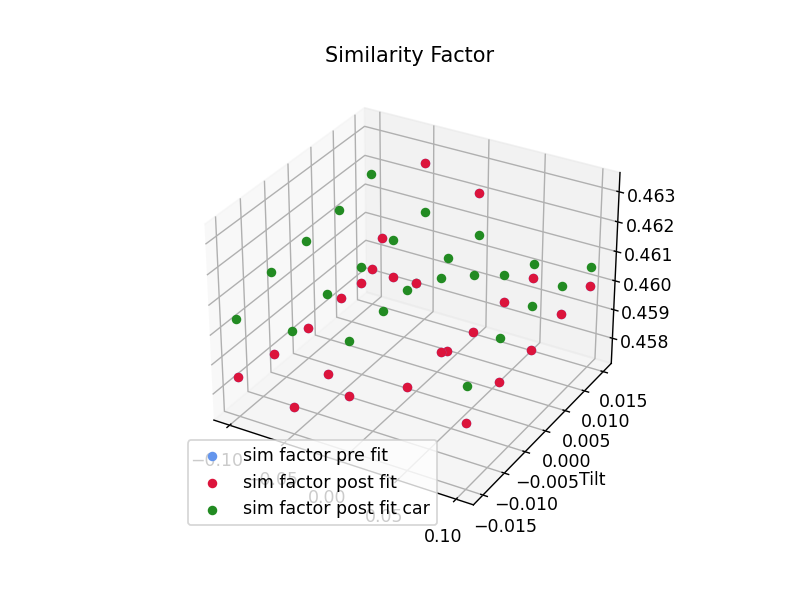

Text(0.5, 0.92, 'Similarity Factor')

In [16]:

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

for n_s in range(N_shifts):
    for n_t in range(N_tilts):
        
        xs = shifts[n_s]
        ys = tilts[n_t]
        zs = factors[n_s][n_t]
        ax.scatter(xs, ys, zs, color= 'cornflowerblue', label = 'sim factor pre fit')
        zs = factors_after[n_s][n_t]
        ax.scatter(xs, ys, zs, color = 'crimson', label = 'sim factor post fit')
        zs = factors_after_car[n_s][n_t]
        ax.scatter(xs, ys, zs, color = 'forestgreen', label = 'sim factor post fit car')


ax.set_ylabel("Shift")
ax.set_ylabel("Tilt")

handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys())
ax.set_title("Similarity Factor")

<IPython.core.display.Javascript object>


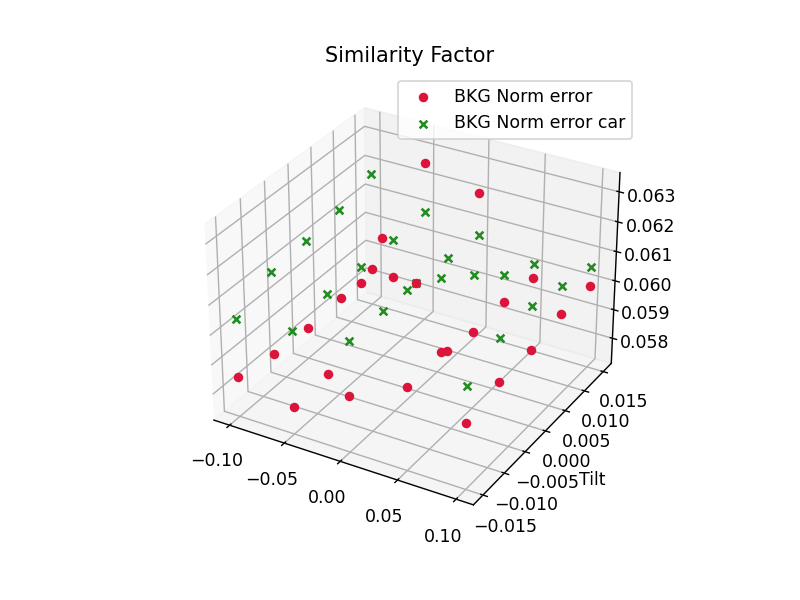

Text(0.5, 0.92, 'Similarity Factor')

In [17]:

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

for n_s in range(N_shifts):
    for n_t in range(N_tilts):
        
        xs = shifts[n_s]
        ys = tilts[n_t]
        zs = factors_after[n_s][n_t]-0.4
        ax.scatter(xs, ys, zs, color = 'crimson',label = "BKG Norm error")
        
        zs = factors_after_car[n_s][n_t]-0.4
        ax.scatter(xs, ys, zs, marker = 'x', color = 'forestgreen',label = "BKG Norm error car")



ax.set_ylabel("Shift")
ax.set_ylabel("Tilt")
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys())
ax.set_title("Similarity Factor")

In [18]:
errors = [d.models.parameters['norm'].error for d in np.array(datasets_after).flatten()]
norms = [d.models.parameters['norm'].value for d in np.array(datasets_after).flatten()]
errors = [e if e <0.8 else np.nan for e in errors]
errors = np.array(errors).reshape(np.shape(datasets_after))

errors_tilts = [d.models.parameters['tilt'].error for d in np.array(datasets_after).flatten()]
tilts_ = [d.models.parameters['tilt'].value for d in np.array(datasets_after).flatten()]
errors_tilts = [_ if _ < 0.8 else np.nan for _ in errors_tilts]
errors_tilts = np.array(errors_tilts).reshape(np.shape(datasets_after))


errors_index = [d.models.parameters['index'].error for d in np.array(datasets_after).flatten()]
indices = [d.models.parameters['index'].value for d in np.array(datasets_after).flatten()]

errors_amplitude = [d.models.parameters['amplitude'].error for d in np.array(datasets_after).flatten()]
amplitudes = [d.models.parameters['amplitude'].value for d in np.array(datasets_after).flatten()]

factors_after = [d for d in np.array(factors_after).flatten()]
factors_shaped = np.array(factors_after).reshape(np.shape(datasets_after))

mean_factor = np.mean(factors_after)
mean_errors = np.mean(factors_after)



In [19]:
errors_car = [d.models.parameters['norm'].error for d in np.array(datasets_after_car).flatten()]
norms_car = [d.models.parameters['norm'].value for d in np.array(datasets_after_car).flatten()]
errors_car = [e if e <0.8 else np.nan for e in errors_car]
errors_car = np.array(errors_car).reshape(np.shape(datasets_after))

errors_tilts_car = [d.models.parameters['tilt'].error for d in np.array(datasets_after_car).flatten()]
tilts__car = [d.models.parameters['tilt'].value for d in np.array(datasets_after_car).flatten()]
errors_tilts_car = [_ if _ < 0.8 else np.nan for _ in errors_tilts_car]
errors_tilts_car = np.array(errors_tilts_car).reshape(np.shape(datasets_after))


errors_index_car = [d.models.parameters['index'].error for d in np.array(datasets_after_car).flatten()]
indices_car = [d.models.parameters['index'].value for d in np.array(datasets_after_car).flatten()]

errors_amplitude_car = [d.models.parameters['amplitude'].error for d in np.array(datasets_after_car).flatten()]
amplitudes_car = [d.models.parameters['amplitude'].value for d in np.array(datasets_after_car).flatten()]

factors_after_car = [d for d in np.array(factors_after_car).flatten()]
factors_shaped_car = np.array(factors_after_car).reshape(np.shape(datasets_after))

mean_factor_car = np.mean(factors_after_car)
mean_errors_car = np.mean(factors_after_car)



<IPython.core.display.Javascript object>


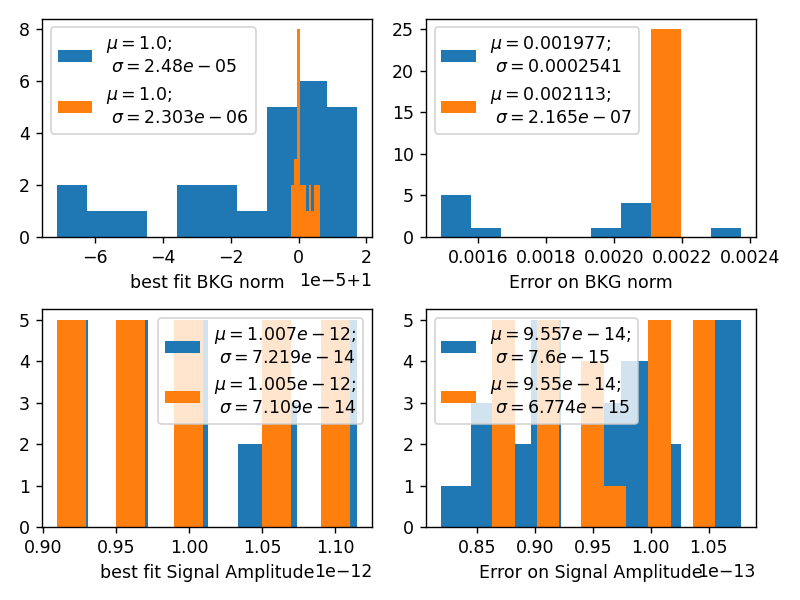

[0.00149172 0.0015799  0.00166808 0.00175626 0.00184444 0.00193262
 0.0020208  0.00210898 0.00219716 0.00228534 0.00237352]


In [20]:
fig, axss = plt.subplots(2,2)
axs = axss[0]
axs[0].hist(np.array(norms).flatten(), label = f"$\mu = {np.nanmean(norms):.4}$;\n $\sigma = {np.nanstd(norms):.4}$" )
axs[0].set_xlabel("best fit BKG norm")
counts, bins, _  = axs[1].hist(np.array(errors).flatten(), label = f"$\mu = {np.nanmean(errors):.4}$;\n $\sigma = {np.nanstd(errors):.4}$" )
print(bins)
axs[0].legend(); axs[1].legend()
axs[1].set_xlabel("Error on BKG norm")
axs = axss[1]
axs[0].hist(amplitudes, label = f"$\mu = {np.mean(amplitudes):.4}$;\n $\sigma = {np.std(amplitudes):.4}$" )
axs[0].set_xlabel("best fit Signal Amplitude")
axs[1].hist(errors_amplitude, label = f"$\mu = {np.mean(errors_amplitude):.4}$;\n $\sigma = {np.std(errors_amplitude):.4}$" )
axs[0].legend(); axs[1].legend()
axs[1].set_xlabel("Error on Signal Amplitude")

axs = axss[0]
axs[0].hist(np.array(norms_car).flatten(), 
            label = f"$\mu = {np.nanmean(norms_car):.4}$;\n $\sigma = {np.nanstd(norms_car):.4}$" )
axs[0].set_xlabel("best fit BKG norm")
axs[1].hist(np.array(errors_car).flatten(), bins = bins,
            label = f"$\mu = {np.nanmean(errors_car):.4}$;\n $\sigma = {np.nanstd(errors_car):.4}$" )
axs[0].legend(); axs[1].legend()
axs[1].set_xlabel("Error on BKG norm")
axs = axss[1]
axs[0].hist(amplitudes_car, 
            label = f"$\mu = {np.mean(amplitudes_car):.4}$;\n $\sigma = {np.std(amplitudes_car):.4}$" )
axs[0].set_xlabel("best fit Signal Amplitude")
axs[1].hist(errors_amplitude_car, 
            label = f"$\mu = {np.mean(errors_amplitude_car):.4}$;\n $\sigma = {np.std(errors_amplitude_car):.4}$" )
axs[0].legend(); axs[1].legend()
axs[1].set_xlabel("Error on Signal Amplitude")

plt.tight_layout()



<IPython.core.display.Javascript object>


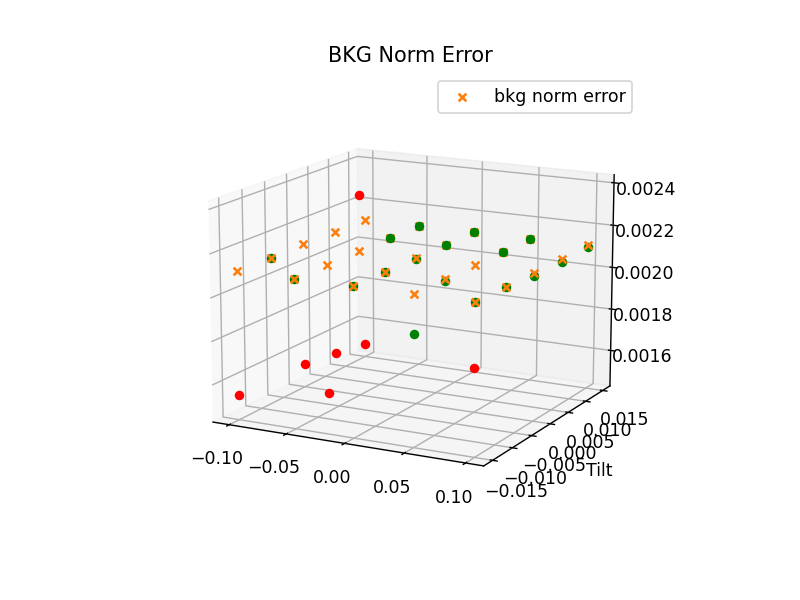

Text(0.5, 0.92, 'BKG Norm Error')

In [29]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
delta = 3e-4
for n_s in range(N_shifts):
    for n_t in range(N_tilts):
        
        xs = shifts[n_s]
        ys = tilts[n_t]
        err = errors[n_s][n_t]
        mean_ = np.nanmean(errors)
        if ((mean_ - delta) > err) or  ((mean_+delta) <err):
            color = 'red'
        else:
            color= 'green'
        zs = err
        ax.scatter(xs, ys, zs, color= color,label = "bkg norm error")
        
        zs = errors_car[n_s][n_t]
        ax.scatter(xs, ys, zs,marker = 'x', color = 'tab:orange',label = "bkg norm error")
        


ax.set_ylabel("Shift")
ax.set_ylabel("Tilt")
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys())
ax.set_title("BKG Norm Error")

<IPython.core.display.Javascript object>


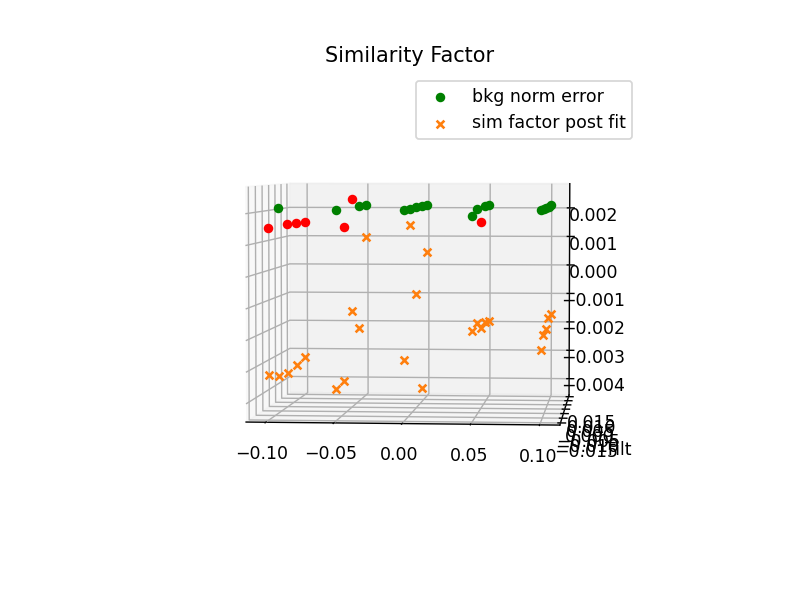

Text(0.5, 0.92, 'Similarity Factor')

In [30]:

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
delta = 3e-4

for n_s in range(N_shifts):
    for n_t in range(N_tilts):
        
        xs = shifts[n_s]
        ys = tilts[n_t]
        err = errors[n_s][n_t]
        mean_ = np.nanmean(errors)
        if ((mean_ - delta) > err) or  ((mean_+delta) <err):
            color = 'red'
        else:
            color= 'green'
        zs = err
        ax.scatter(xs, ys, zs, color= color,label = "bkg norm error")
        zs = factors_shaped[n_s][n_t]-mean_factor - 0.002
        ax.scatter(xs, ys, zs,  marker = 'x', color = 'tab:orange',label = "sim factor post fit")


ax.set_ylabel("Shift")
ax.set_ylabel("Tilt")
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys())
ax.set_title("Similarity Factor")

<IPython.core.display.Javascript object>


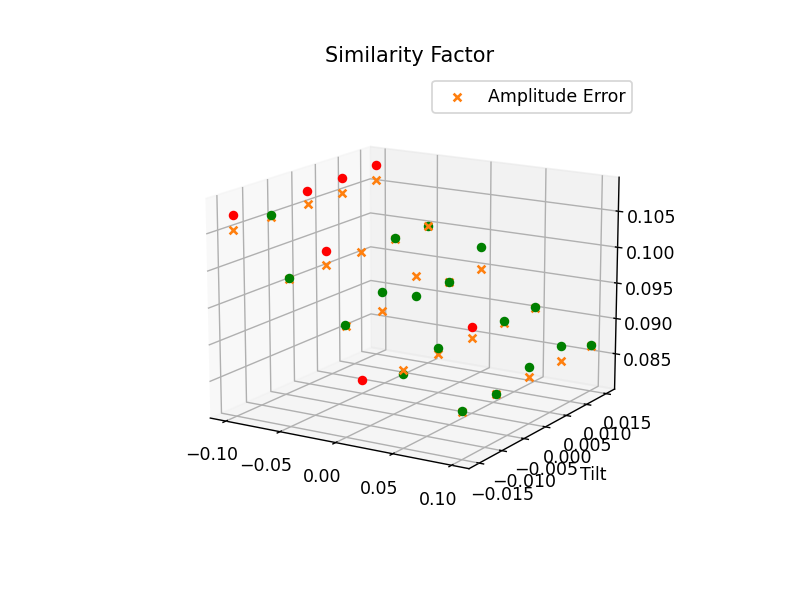

Text(0.5, 0.92, 'Similarity Factor')

In [31]:


fig = plt.figure()
ax = fig.add_subplot(projection='3d')

for n_s in range(N_shifts):
    for n_t in range(N_tilts):
        
        xs = shifts[n_s]
        ys = tilts[n_t]
        err = datasets_after[n_s][n_t].models.parameters['norm'].error
        mean_ = np.nanmean(errors)
        if ((mean_ - delta) > err) or  ((mean_+delta) <err):
            color = 'red'
        else:
            color= 'green'
        zs = datasets_after[n_s][n_t].models.parameters['amplitude'].error * 1e12
        ax.scatter(xs, ys, zs,  marker = 'o', color = color,label = "Amplitude Error")
        
        zs = datasets_after_car[n_s][n_t].models.parameters['amplitude'].error * 1e12
        ax.scatter(xs, ys, zs,  marker = 'x', color = 'tab:orange',label = "Amplitude Error")
        
ax.set_ylabel("Shift")
ax.set_ylabel("Tilt")
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys())
ax.set_title("Similarity Factor")

<IPython.core.display.Javascript object>


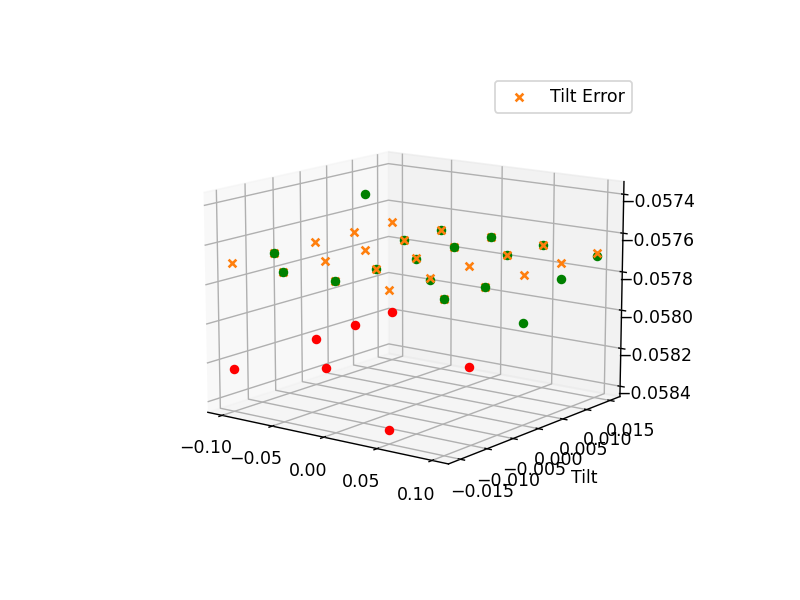

In [32]:


fig = plt.figure()
ax = fig.add_subplot(projection='3d')

for n_s in range(N_shifts):
    for n_t in range(N_tilts):
        
        xs = shifts[n_s]
        ys = tilts[n_t]
        err = datasets_after[n_s][n_t].models.parameters['norm'].error
        mean_ = np.nanmax(errors)
        if ((mean_ - delta) > err) or  ((mean_+delta) <err):
            color = 'red'
        else:
            color= 'green'
        zs = err
        zs = errors_tilts[n_s][n_t] - 0.06
        ax.scatter(xs, ys, zs,  marker = 'o', color = color,label = "Tilt Error")
        
        zs = errors_tilts_car[n_s][n_t] - 0.06
        ax.scatter(xs, ys, zs,  marker = 'x', color = 'tab:orange',label = "Tilt Error")
        
ax.set_ylabel("Shift")
ax.set_ylabel("Tilt")
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys())


<IPython.core.display.Javascript object>


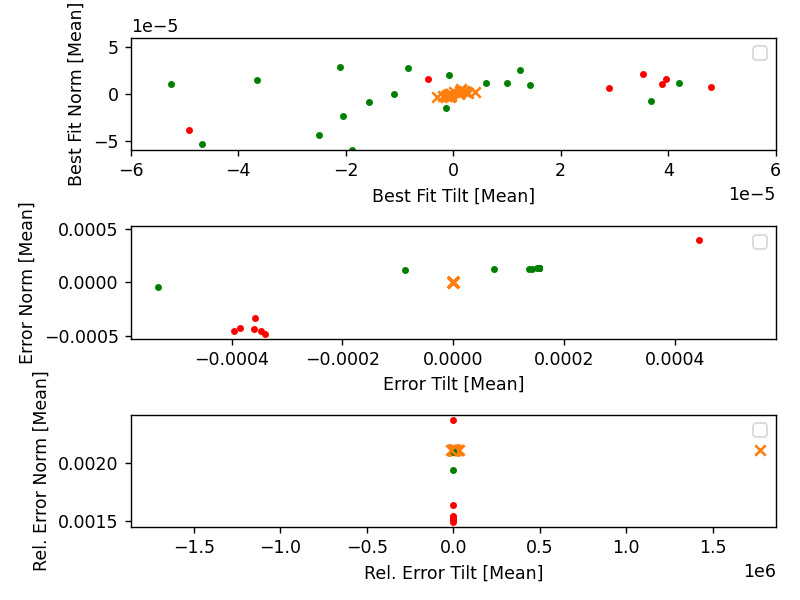

/tmp/ipykernel_18165/2310875609.py:10: RuntimeWarning: divide by zero encountered in double_scalars
  rel_tilt= errors_tilts.flatten()[i] / tilts_[i]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


In [33]:
fig,axs = plt.subplots(3,1)
delta_ = 2e-4
for i in range(len(tilts_)):
    error_tilt = errors_tilts.flatten()[i] - np.nanmean(errors_tilts)
    error_norm = errors.flatten()[i] - np.nanmean(errors.flatten())
    tilt = tilts_[i] - np.mean(tilts_)
    norm = norms[i] - np.mean(norms)
    rel_norm =  errors.flatten()[i] / norms[i]
    try:
        rel_tilt= errors_tilts.flatten()[i] / tilts_[i]
    except:
        rel_tilt= errors_tilts.flatten()[i] 
    
    color = 'green'
    if np.abs(error_norm) > delta_:
        color = 'red'
    axs[1].scatter(error_tilt, error_norm, marker = '.', color= color)
    axs[0].scatter(tilt, norm, marker = '.', color = color)
    axs[2].scatter(rel_tilt, rel_norm,  marker = '.', color = color)

    
    error_tilt = errors_tilts_car.flatten()[i] - np.nanmean(errors_tilts_car)
    error_norm = errors_car.flatten()[i] - np.nanmean(errors_car.flatten())
    tilt = tilts__car[i] - np.mean(tilts__car)
    norm = norms_car[i] - np.mean(norms_car)
    rel_norm =  errors_car.flatten()[i] / norms_car[i]
    try:
        rel_tilt= errors_tilts_car.flatten()[i] / tilts__car[i]
    except:
        rel_tilt= errors_tilts_car.flatten()[i] 
    
    axs[1].scatter(error_tilt, error_norm, marker = 'x', color= 'tab:orange')
    axs[0].scatter(tilt, norm, marker = 'x', color = 'tab:orange')
    axs[2].scatter(rel_tilt, rel_norm,  marker = 'x', color = 'tab:orange')
    
    
axs[0].set_xlabel("Best Fit Tilt [Mean]")
axs[0].set_ylabel("Best Fit Norm [Mean]") 

axs[1].set_xlabel("Error Tilt [Mean]")
axs[1].set_ylabel("Error Norm [Mean]")    

axs[2].set_xlabel("Rel. Error Tilt [Mean]")
axs[2].set_ylabel("Rel. Error Norm [Mean]")    
    
colors_cases = ['black', 'blue', 'orange']
'''for i, case in enumerate(['neg', 'pos', 'cor']):    
    models_neg = Models.read(f"data/1_model_{case}.yml")
    axs[0].scatter(models_neg.parameters['tilt'].value - np.mean(tilts_),
                   models_neg.parameters['norm'].value - np.mean(norms),
                   marker = 'x', color = colors_cases[i], s = 40 )    
    axs[1].scatter(models_neg.parameters['tilt'].error - np.mean(errors_tilts),
                   models_neg.parameters['norm'].error - np.mean(errors),
                   marker = 'x', color = colors_cases[i], s = 40 )     
    try:
        rel_tilt=models_neg.parameters['tilt'].error /models_neg.parameters['tilt'].value
    except:
        rel_tilt=models_neg.parameters['tilt'].error 
    axs[2].scatter(rel_tilt,
                   models_neg.parameters['norm'].error /models_neg.parameters['norm'].value,
                   marker = 'x', color = colors_cases[i], s = 40,
                  label = case)        '''
axs[0].set_ylim(-6e-5, 6e-5)
axs[0].set_xlim(-6e-5, 6e-5)

low, high = axs[1].get_ylim()
bound = max(abs(low), abs(high))
axs[1].set_ylim(-bound, bound)
low, high = axs[1].get_xlim()
bound = max(abs(low), abs(high))
axs[1].set_xlim(-bound, bound)

low, high = axs[2].get_ylim()
bound = max(abs(low), abs(high))
#axs[2].set_ylim(-bound, bound)
low, high = axs[2].get_xlim()
bound = max(abs(low), abs(high))
axs[2].set_xlim(-bound, bound)

for a in axs:
    a.legend()


plt.tight_layout()

In [26]:
stat_sums = [d.stat_sum() for d in np.array(datasets_after).flatten()]

<IPython.core.display.Javascript object>


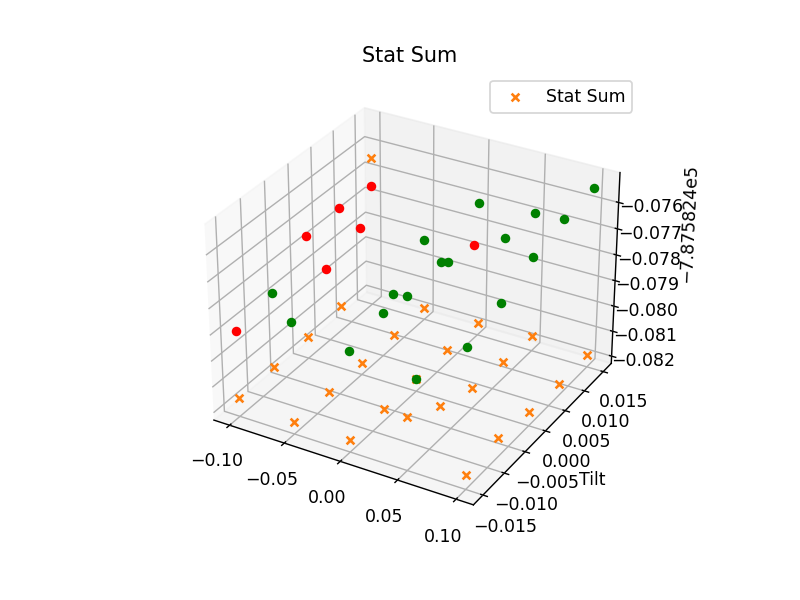

Text(0.5, 0.92, 'Stat Sum')

In [54]:

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

for n_s in range(N_shifts):
    for n_t in range(N_tilts):
        
        xs = shifts[n_s]
        ys = tilts[n_t]
        err = errors[n_s][n_t]
        mean_ = np.nanmean(errors)
        if ((mean_ - delta) > err) or  ((mean_+delta) <err):
            color = 'red'
        else:
            color= 'green'
        
        zs = datasets_after[n_s][n_t].stat_sum()# - np.mean(stat_sums) - 0.02
        ax.scatter(xs, ys, zs,  marker = 'o', color = color,label = "Stat Sum")
        
        
        zs = datasets_after_car[n_s][n_t].stat_sum() #- np.mean(stat_sums) - 0.02
        ax.scatter(xs, ys, zs,  marker = 'x', color = 'tab:orange',label = "Stat Sum")
        
ax.set_ylabel("Shift")
ax.set_ylabel("Tilt")
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys())
ax.set_title("Stat Sum")

<IPython.core.display.Javascript object>


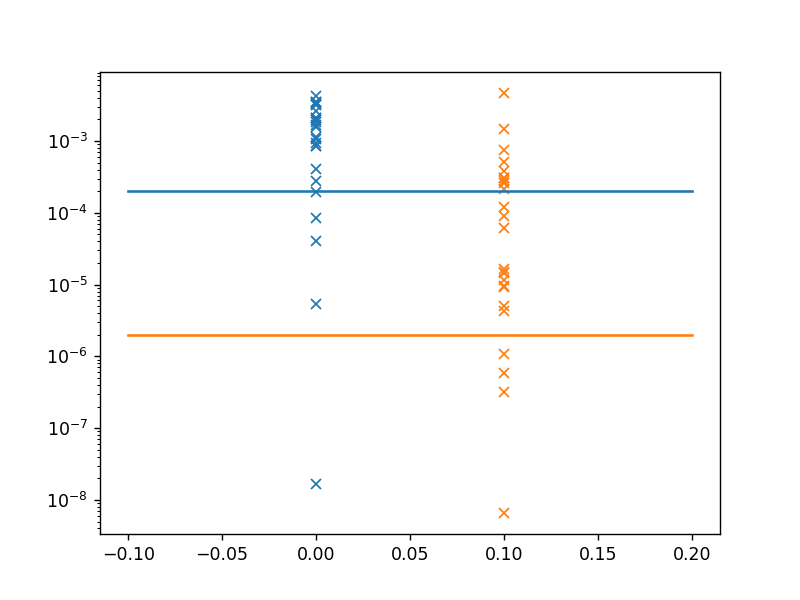

In [52]:
fig = plt.figure()

edms = [f.minuit.fmin.edm for f in np.array(fits).flatten()]
edms_car = [f.minuit.fmin.edm for f in np.array(fits_car).flatten()]

for i in range(len(edms)):
    plt.plot(0, edms[i], 'x', color = 'tab:blue')
    plt.plot(0.1, edms_car[i], 'x', color = 'tab:orange')

plt.plot([-0.1, 0.2], [fits[0][0].minuit.fmin.edm_goal] * 2 , color = 'tab:blue')    
plt.plot([-0.1, 0.2], [fits_car[0][0].minuit.fmin.edm_goal] * 2 , color = 'tab:orange')    

    
plt.yscale("log")  